In [1]:
from scipy.sparse import dok_matrix
from switss.model import DTMC, ReachabilityForm

It seems that graph_tool is not installed, you will not be able to use the treealgo.


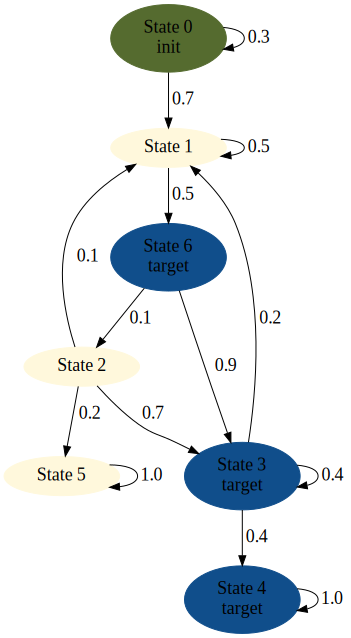

In [2]:
P = [[0.3, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0],
     [0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.5],
     [0.0, 0.1, 0.0, 0.7, 0.0, 0.2, 0.0],
     [0.0, 0.2, 0.0, 0.4, 0.4, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
     [0.0, 0.0, 0.1, 0.9, 0.0, 0.0, 0.0]]

labels = {    "target" : {3,4,6},
              "init" : {0} }

mc = DTMC(P, labels)
mc.index_by_state_action
mc.digraph()

In [ ]:
rf,_,_ = ReachabilityForm.reduce(mc, "init", "target")
rf.system.digraph()

In [ ]:
tra_path, lab_path = rf.system.save("datasets/toy")
print("saved at %s, %s" % (tra_path, lab_path))
mcrf_loaded = DTMC.from_file(lab_path, tra_path)
rf = ReachabilityForm(mcrf_loaded, "init")
rf.system.digraph()

In [ ]:
M = DTMC.from_prism_model("datasets/brp.pm",
                          prism_constants={("N",2),("MAX",1)},
                          extra_labels={("uncertain","s=5 & srep=2"),("all","true")})
M.digraph()